# Simulating noisy quantum circuits with Paddle Quantum

<em> Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## Introduction to quantum noises

In ideal models, we usually assume that quantum circuits are operating on a **closed physical system**. However, real quantum devices suffer from **incoherent noises** introduced by unwanted interactions between the system and the environment. This type of noise can significantly change the performance of quantum computation tasks and hence can hardly be ignored for near-term quantum devices. Consequently, designing robust quantum algorithms under the presence of noise is crucial for utilizing quantum computation in the real world. With the noise module of Paddle Quantum, we can now not only design and simulate quantum algorithms but also examine various noises' influence and further develop error mitigation schemes.

## Building noise models in Paddle Quantum

### Noise model and quantum channel
 
The evolution of a closed quantum system is always unitary. Mathematically, we can describe such a process as implementing a parameterized quantum circuit $U(\vec{\theta})$,

$$
\rho \longrightarrow U(\vec{\theta}) \rho U^\dagger(\vec{\theta}),
\tag{1}
$$

where $\rho$ is the initial quantum state, $\vec{\theta}$ is a vector containing all the parameters. The most intuitive type of noise one can think of is the error that appears in these parameters, 
$$
\rho \longrightarrow U(\vec{\theta}+\vec{\epsilon}) \rho U^\dagger(\vec{\theta}+\vec{\epsilon}),
\tag{2}
$$

$\vec{\epsilon}$ can be a white noise sampled from Gaussian distributions. This kind of noise is a specific example of **coherent noises**. Coherent noise usually occurs due to device calibration errors or quantum control errors. We want to emphasize that one also uses unitary transformation $U(\vec{\epsilon})$ to describe coherent noises. In certain cases, coherent noises can be more damaging than incoherent noises [1].  

Most of the time, the real problem lies on the evolution of an **open quantum system** that is non-unitary. Under this circumstance, we need a more general description beyond the unitary transformation to characterize incoherent noises, the language of **quantum channels**. To keep the discussion precise, we use *operator-sum representation* [2] to introduce a quantum channel as 

$$
\mathcal{E}(\rho) =  \sum_{k=0}^{m-1} E_k \rho E_k^{\dagger},
\tag{3}
$$

where $\{E_k\}$ are *Kraus* operators, and they satisfy the completeness condition  $\sum_k E_k^\dagger E_k = I$. Mathematically, a quantum channel is completely positive and trace-preserving [2].

Under this representation, we can explicitly observe the results of implementing a quantum channel: Suppose we start with a pure state $\rho = |\psi\rangle\langle \psi|$, then we send it through a noisy quantum channel (e.g., $m = 2$ ). Eventually, we will get a mixed state $\mathcal{E}(\rho) = E_0 \rho E_0^\dagger + E_1 \rho E_1^\dagger$. Let's take the bit flip noise as an example: 

$$
\mathcal{E}_{BF}(\rho) = (1 - p) I \rho I+ p X \rho X,
\tag{4}
$$

where $X,I$ are Pauli operators. The corresponding *Kraus* operators are:

$$
E_0 = \sqrt{1-p}
\begin{bmatrix}
1&0 \\
0&1
\end{bmatrix},
E_1 = \sqrt{p}
\begin{bmatrix}
0& 1 \\
1 &0
\end{bmatrix}.
\tag{5}
$$

The physical meaning of this quantum channel is there exist a  probability $p$ that the state $|0\rangle$ will flip into $|1\rangle$, and vice versa. In Paddle Quantum, we can use this quantum channel by `UAnsatz.bit_flip(p, which_qubit)`, where `p` is the noise level.

**Note:** For a quantum channel, the Kraus operator representation is not necessarily unique [3].

### Implementation with Paddle Quantum

In this section, we will learn how to build a noise model in Paddle Quantum. First, we initialize a qubit to $|0\rangle$. 

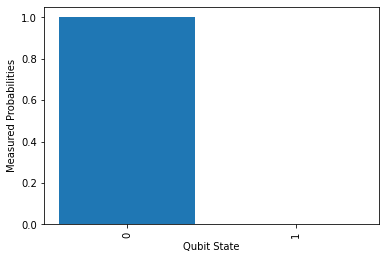

{'0': 1024}

In [1]:
import paddle
from paddle_quantum.circuit import UAnsatz

# Define the number of qubits, here we use one single qubit
num_qubits = 1

# Initialize the quantum circuit
cir = UAnsatz(num_qubits)

# Initialize the qubit to |0><0| 
init_state = cir.run_density_matrix()

# Mesure in the computational basis 
cir.measure(plot=True)

Then, we add a bit flip channel with $p=0.1$, and measure the qubit after this channel.
**Note:** Noisy module in Paddle Quantum only supports density matrix operation mode.

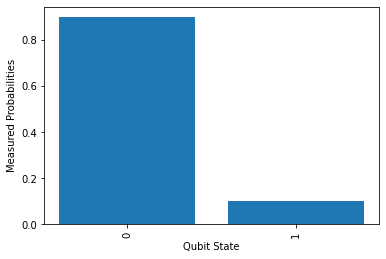

Quantum state after the bit flip quantum channel：
 [[0.9+0.j 0. +0.j]
 [0. +0.j 0.1+0.j]]


In [2]:
# Noise level
p = 0.1

# Add the bit flip noisy channel
cir.bit_flip(p, 0)

# Execute the circuit
# Note: Noisy module in Paddle Quantum only supports density matrix operation mode
fin_state = cir.run_density_matrix()

# Measure in the computational basis
cir.measure(plot=True)
print('Quantum state after the bit flip quantum channel：\n', fin_state.numpy())

As we can see, the quantum state has been transformed to a mixed state $0.9 | 0 \rangle \langle 0 | + 0.1 | 1 \rangle \langle 1 |$ (with probability $p=0.1$ ) after the bit flip channel.


### Common quantum channels

Paddle Quantum supports many other common noisy channels.

- **Phase Flip Channel**

  Similar to the bit-flip channel, the phase flip channel flips the phase of a qubit with probability $p$, 
  
  $$
  \mathcal{E}_{PF}(\rho) =  (1 - p) \rho + p Z \rho Z.
  \tag{6}
  $$


- **Bit-Phase Flip Channel**

  $$
  \mathcal{E}_{BPF}(\rho) = (1-p) \rho + p Y \rho Y.
  \tag{7}
  $$


- **Depolarizing Channel**

  The quantum state will be in the maximally mixed state $I/2$ with probability $p$ or in the original state with probability $1-p$ after the single qubit depolarizing channel. The depolarizing channel can also be understood as applying Pauli noises symmetrically, 
  
  $$
  \mathcal{E}_{D}(\rho) = (1 - p) \rho + \frac{p}{3}
  \left( X \rho X+ Y \rho Y + Z \rho Z \right).
  \tag{8}
  $$


- **Pauli Channel**

  The Pauli channel applies Pauli noises asymmetrically, 
  
  $$
  \mathcal{E}_{Pauli}(\rho) = (1 - p_x - p_y - p_z) \rho + p_x X \rho X + p_y Y \rho Y + p_z Z \rho Z.
  \tag{9}
  $$


- **Amplitude Damping Channel**

  The amplitude damping channel can be used to model the process of **energy dissipation**, 
  
  $$
  \mathcal{E}_{AD}(\rho) = E_0 \rho E_0^\dagger + E_1 \rho E_1^\dagger,
  \tag{10}
  $$
  
  where $\gamma$ is the damping factor,
  
  $$
  E_0 = 
  \begin{bmatrix}
   1 & 0 \\ 0 & \sqrt{1 - \gamma}
  \end{bmatrix},
  E_1 = 
  \begin{bmatrix}
   0 & \sqrt{\gamma} \\ 0 & 0
  \end{bmatrix}.
  \tag{11}
  $$ 


- **Phase Damping Channel**

  The phase damping channel describes the loss of **quantum information** without loss of energy, 
  
  $$
  \mathcal{E}_{PD}(\rho) = E_0 \rho E_0^\dagger + E_1 \rho E_1^\dagger,
  \tag{12}
  $$
  
  where $\gamma$ is the damping factor，
  
  $$
  E_0 = 
  \begin{bmatrix}
   1 & 0 \\ 0 & \sqrt{1 - \gamma}
  \end{bmatrix}, 
  E_1 = 
  \begin{bmatrix}
   0 & 0 \\ 0 & \sqrt{\gamma}
  \end{bmatrix}.
  \tag{13}
  $$


- **Generalized Amplitude Damping Channel**

  The generalized amplitude damping channel describes energy exchange between the system and the environment at **finite temperatures**. It is a common noise in superconducting quantum computations [4]. Interested readers can find more information here [API document](https://qml.baidu.com/api/paddle_quantum.circuit.uansatz.html).


**Note：** In Paddle Quantum, we can use these noisy channels through `UAnsatz.phase_flip()`, `UAnsatz.bit_phase_flip()`, `UAnsatz.depolarizing()`, `UAnsatz.pauli_channel()`, `UAnsatz.amplitude_damping()`, `UAnsatz.phase_damping()`, and `UAnsatz.generalized_amplitude_damping()`.

**Note：** One usually choose the amplitude damping channel and the phase damping channel to model noises since they describe the physical process in real quantum systems (modeling $T_1$ and $T_2$ process).

### Customized Channel

One can also use `UAnsatz.customized_channel()` in Paddle Quantum to add customized noisy channels. This is accomplished through user-defined Kraus operators. Here, we provide an example to reproduce the bit flip channel using customized_channel function:

In [3]:
import paddle
import numpy as np
from paddle_quantum.circuit import UAnsatz

# Noise level
p = 0.1

# We use customized Kraus operator to represent the bit flip channel
# Note that the data type of a Kraus operator is complex_128
a_0 = paddle.to_tensor(np.sqrt(1 - p) * np.array([[1, 0], [0, 1]], dtype='complex128'))
a_1 = paddle.to_tensor(np.sqrt(p) * np.array([[0, 1], [1, 0]], dtype='complex128'))
Kraus_ops = [a_0, a_1]

# Initialize the circuit
num_qubits = 1
cir = UAnsatz(num_qubits)

# Add customized channel, input is a list of Kraus operators
cir.customized_channel(Kraus_ops, 0)

# Execute the circuit
fin_state = cir.run_density_matrix()


# Compare the results
cir_1 = UAnsatz(num_qubits)
cir_1.bit_flip(p, 0)
fin_state_1 = cir_1.run_density_matrix()
print('quantum state after the customized channel:\n', fin_state.numpy())
print('\n quantum state after the bit flip channel：\n', fin_state_1.numpy())
print('\n are the two the same？', bool((fin_state - fin_state_1).abs().sum() < 1e-8))

quantum state after the customized channel:
 [[0.9+0.j 0. +0.j]
 [0. +0.j 0.1+0.j]]

 quantum state after the bit flip channel：
 [[0.9+0.j 0. +0.j]
 [0. +0.j 0.1+0.j]]

 are the two the same？ True


## Discussion: Simulating noisy entanglement resources with Paddle Quantum

Many important quantum technologies require pre-shared entanglement resources, including quantum teleportation, state transformation, and distributed quantum computing. For instance, we want the allocated entanglement resources are in **maximally entangled states** under ideal circumstances. But in reality, noise always exists due to interactions between the system and the environment during preparation stage, transmission, and preservation. Here, we use the depolarized channel to simulate how a white noise could affect Bell states: 

In [4]:
import paddle
from paddle import matmul, trace
from paddle_quantum.circuit import UAnsatz
from paddle_quantum.state import bell_state

# Noise level
p_trans = 0.1
p_store = 0.01

# Initialize the circuit
num_qubits = 2
cir = UAnsatz(num_qubits)

# The initial state is Bell state
init_state = paddle.to_tensor(bell_state(2))

# Apply the depolarized channel to each qubit, modeling the noise introduced by transmission
cir.depolarizing(p_trans, 0)
cir.depolarizing(p_trans, 1)

# Execute the circuit 
status_mid = cir.run_density_matrix(init_state)

# Apply the amplitude damping channel to each qubit, modeling the noise introduced by storage
cir.amplitude_damping(p_store, 0)
cir.amplitude_damping(p_store, 1)

# Execute the circuit
status_fin = cir.run_density_matrix(status_mid)
fidelity_mid = paddle.real(trace(matmul(init_state, status_mid)))
fidelity_fin = paddle.real(trace(matmul(init_state, status_fin)))

print("Fidelity between the initial state and the Bell state", 1)
print("after transmission (depolarized channel), the fidelity between the entangled state and Bell state {:.5f}".format(fidelity_mid.numpy()[0]))
print("after preservation (amplitude damping channel), the fidelity between the entangled state and Bell state {:.5f}".format(fidelity_fin.numpy()[0]))

Fidelity between the initial state and the Bell state 1
after transmission (depolarized channel), the fidelity between the entangled state and Bell state 0.81333
after preservation (amplitude damping channel), the fidelity between the entangled state and Bell state 0.66752


**Note：** Interested readers can check tutorials on the LOCCNet module of Paddle Quantum, where we discuss the concept of [entanglement distillation](https://qml.baidu.com/tutorials/loccnet/entanglement-distillation-with-loccnet.html).

## Application: Simulating noisy VQE with Paddle Quantum


Variational Quantum Eigensolver (VQE) [5] is designed to find the ground state energy of a given molecular Hamiltonian using variational quantum circuits. Interested readers can find more details from the previous tutorial [VQE](https://qml.baidu.com/tutorials/variational-quantum-eigensolver.html).

For illustration purposes, we use VQE to find the ground state energy for the following Hamiltonian: 

$$ 
H = 0.4 \, Z \otimes I + 0.4 \, I \otimes Z + 0.2 \, X \otimes X. 
\tag{14}
$$

Then, we add the amplitude damping channel and compare the performance of the noisy circuit and the noiseless circuit on this task:

In [5]:
import numpy as np
import paddle
from paddle_quantum.circuit import UAnsatz
from paddle_quantum.utils import pauli_str_to_matrix

# Construct Hamiltonian using Pauli string
H_info = [[0.4, 'z0'], [0.4, 'z1'], [0.2, 'x0,x1']]

# Convert the Pauli string to a matrix
H_matrix = pauli_str_to_matrix(H_info, num_qubits)

# Hyperparameters
num_qubits = 2
theta_size = 4
ITR = 100
LR = 0.4
SEED = 999    
p = 0.1

In [6]:
class vqe_noisy(paddle.nn.Layer):
    
    def __init__(self, shape, dtype='float64'):
        super(vqe_noisy, self).__init__()
        
        # Initialize a learnable parameter list with length theta_size, initial values are sampled from uniform distribution between [0, 2*pi]
        self.theta = self.create_parameter(shape=shape, 
                                           default_initializer=paddle.nn.initializer.Uniform(low=0., high=2*np.pi), 
                                           dtype=dtype, is_bias=False)
        
    # Define loss function and forward function
    def forward(self):
        
        # Initialize circuit
        cir = UAnsatz(num_qubits)
        
        # Add parameterized gates
        cir.ry(self.theta[0], 0)
        cir.ry(self.theta[1], 1)
        
        cir.cnot([0, 1])
        
        cir.ry(self.theta[2], 0)
        cir.ry(self.theta[3], 1)
        
        # Add amplitude damping channel
        cir.amplitude_damping(p, 0)
        cir.amplitude_damping(p, 1)
        
        # Execute the circuit
        cir.run_density_matrix()
        
        # Expectation value of Hamiltonian 
        loss = cir.expecval(H_info)
        
        return loss
    
# Construct a noiseless circuit
class vqe_noise_free(paddle.nn.Layer):
    
    def __init__(self, shape, dtype='float64'):
        super(vqe_noise_free, self).__init__()
        
        self.theta = self.create_parameter(shape=shape, 
                                           default_initializer=paddle.nn.initializer.Uniform(low=0., high=2*np.pi), 
                                           dtype=dtype, is_bias=False)
        
    def forward(self):
        
        cir = UAnsatz(num_qubits)
        cir.ry(self.theta[0], 0)
        cir.ry(self.theta[1], 1) 
        cir.cnot([0, 1])
        cir.ry(self.theta[2], 0)
        cir.ry(self.theta[3], 1)
        cir.run_density_matrix()
        loss = cir.expecval(H_info)
        
        return loss
    
# Train noisy VQE circuit
print('========== Training Noisy VQE ==========')
loss_list = []
parameter_list = []

# Define the dimension of parameters
vqe = vqe_noisy([theta_size])

# Generally, we use Adam optimizer to get a better convergence, you can change to SVG or RMS prop.
opt = paddle.optimizer.Adam(learning_rate = LR, parameters = vqe.parameters())    

# Optimization iteration
for itr in range(ITR):

    # Forward, to calculate loss function
    loss = vqe()

    # Backpropagate to minimize the loss function
    loss.backward()
    opt.minimize(loss)
    opt.clear_grad()

    # Record the learning curve
    loss_list.append(loss.numpy()[0])
    parameter_list.append(vqe.parameters()[0].numpy())
    if itr % 10 == 0:
        print('iter:', itr, '  loss: %.4f' % loss.numpy())
        
# Train the noiseless VQE in the same way
print('========== Training Noise Free VQE ==========')
loss_list_no_noise = []
parameter_list_no_noise = []

vqe_no_noise = vqe_noise_free([theta_size])
opt_no_noise = paddle.optimizer.Adam(learning_rate = LR, parameters = vqe_no_noise.parameters())    

for itr in range(ITR):

    loss = vqe_no_noise()

    loss.backward()
    opt_no_noise.minimize(loss)
    opt_no_noise.clear_grad()

    loss_list_no_noise.append(loss.numpy()[0])
    parameter_list_no_noise.append(vqe_no_noise.parameters()[0].numpy())
    if itr % 10 == 0:
        print('iter:', itr, '  loss: %.4f' % loss.numpy())


print('\nGround state energy from noisy circuit: ', loss_list[-1], "Ha")
print('Ground state energy from noiseless circuit: ', loss_list_no_noise[-1], "Ha")
print('Actual ground state energy: ', np.linalg.eigh(H_matrix)[0][0], "Ha")

========== Training Noisy VQE ==========
iter: 0   loss: 0.1974
iter: 10   loss: -0.6107
iter: 20   loss: -0.6515
iter: 30   loss: -0.6567
iter: 40   loss: -0.6600
iter: 50   loss: -0.6620
iter: 60   loss: -0.6618
iter: 70   loss: -0.6621
iter: 80   loss: -0.6621
iter: 90   loss: -0.6621
========== Training Noise Free VQE ==========
iter: 0   loss: -0.5251
iter: 10   loss: -0.7949
iter: 20   loss: -0.8090
iter: 30   loss: -0.8227
iter: 40   loss: -0.8241
iter: 50   loss: -0.8242
iter: 60   loss: -0.8246
iter: 70   loss: -0.8246
iter: 80   loss: -0.8246
iter: 90   loss: -0.8246

Ground state energy from noisy circuit:  -0.6621521112461377 Ha
Ground state energy from noiseless circuit:  -0.8246151650552795 Ha
Actual ground state energy:  -0.8246211251235321 Ha


As we can see, noisy VQE behaves much worse than the noiseless version as expected and couldn't satisfy chemical accuracy $\varepsilon = 0.0016$ Ha.

## Conclusion

Noise is an unavoidable feature of quantum devices in the NISQ era. Therefore, designing robust quantum algorithms under the presence of noise and further developing error mitigation schemes are two important research directions. With the noise module in Paddle Quantum, we hope to provide a platform simulating real physical systems and help developing near-term quantum computation applications. Standing together with the research community, the noise module will help us explore what we can achieve with noisy devices, design more robust quantum algorithms, and eventually leads to trustworthy quantum solutions in areas including AI and quantum chemistry.


---

## References

[1] Iverson, J. K., & Preskill, J. Coherence in logical quantum channels. [New Journal of Physics, 22(7), 073066 (2020).](https://iopscience.iop.org/article/10.1088/1367-2630/ab8e5c)

[2] Nielsen, M. A. & Chuang, I. L. Quantum computation and quantum information. Cambridge university press (2010).

[3] Preskill, J. Quantum Information Lecture Notes. Chapter 3 (2018).

[4] Chirolli, L., & Burkard, G. Decoherence in solid-state qubits. [Advances in Physics, 57(3), 225-285 (2008).](https://www.tandfonline.com/doi/abs/10.1080/00018730802218067)

[5] Peruzzo, A. et al. A variational eigenvalue solver on a photonic quantum processor. [Nat. Commun. 5, 4213 (2014).](https://www.nature.com/articles/ncomms5213)